In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme()


In [2]:
# Generate data
hourly_f1 = list(np.random.randint(low=94, high=98, size=24*20)) + \
            list(np.random.randint(low=92, high=96, size=24*5)) + \
            list(np.random.randint(low=88, high=96, size=24*5)) + \
            list(np.random.randint(low=86, high=92, size=24*5))
hourly_f1

[94,
 94,
 97,
 95,
 96,
 95,
 96,
 94,
 95,
 94,
 95,
 97,
 95,
 97,
 95,
 96,
 94,
 94,
 95,
 96,
 96,
 96,
 94,
 97,
 95,
 95,
 95,
 97,
 95,
 96,
 97,
 94,
 96,
 96,
 94,
 96,
 95,
 94,
 96,
 94,
 95,
 94,
 96,
 95,
 97,
 96,
 96,
 96,
 97,
 94,
 96,
 94,
 97,
 94,
 96,
 95,
 97,
 97,
 94,
 94,
 96,
 94,
 96,
 96,
 94,
 95,
 95,
 94,
 94,
 94,
 97,
 94,
 96,
 95,
 97,
 96,
 97,
 94,
 97,
 94,
 95,
 97,
 96,
 97,
 97,
 94,
 97,
 94,
 95,
 94,
 97,
 94,
 97,
 96,
 95,
 94,
 94,
 97,
 95,
 96,
 97,
 94,
 96,
 94,
 97,
 95,
 96,
 96,
 96,
 96,
 97,
 95,
 97,
 94,
 96,
 97,
 94,
 97,
 95,
 95,
 95,
 95,
 95,
 95,
 96,
 96,
 94,
 94,
 95,
 95,
 95,
 95,
 95,
 96,
 97,
 94,
 95,
 96,
 95,
 97,
 97,
 97,
 97,
 97,
 96,
 95,
 97,
 94,
 94,
 94,
 95,
 97,
 94,
 96,
 95,
 95,
 97,
 97,
 96,
 94,
 96,
 95,
 95,
 94,
 96,
 94,
 95,
 97,
 94,
 94,
 94,
 95,
 95,
 97,
 96,
 94,
 94,
 96,
 94,
 97,
 94,
 95,
 95,
 97,
 97,
 96,
 96,
 95,
 96,
 94,
 96,
 97,
 96,
 94,
 95,
 97,
 95,
 96,
 94,
 97,


In [3]:
# Cumulative f1
cumulative_f1 = [np.mean(hourly_f1[:n]) for n in range(1, len(hourly_f1)+1)]
print (f"Average cumulative f1 on the last day: {np.mean(cumulative_f1[-24:]):.1f}")


Average cumulative f1 on the last day: 93.8


In [4]:
# Sliding f1
window_size = 24
sliding_f1 = np.convolve(hourly_f1, np.ones(window_size)/window_size, mode="valid")
print (f"Average sliding f1 on the last day: {np.mean(sliding_f1[-24:]):.1f}")


Average sliding f1 on the last day: 88.7


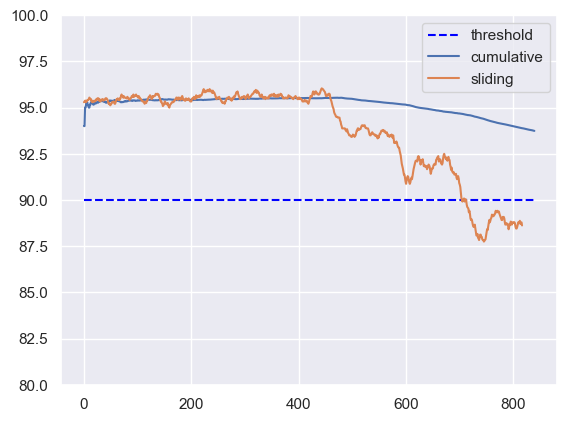

In [5]:
plt.ylim([80, 100])
plt.hlines(y=90, xmin=0, xmax=len(hourly_f1), colors="blue", linestyles="dashed", label="threshold")
plt.plot(cumulative_f1, label="cumulative")
plt.plot(sliding_f1, label="sliding")
plt.legend()


We may need to monitor metrics at various window sizes to catch performance degradation as soon as possible. Here we're monitoring the overall f1 but we can do the same for slices of data, individual classes, etc. For example, if we monitor the performance on a specific tag, we may be able to quickly catch new algorithms that were released for that tag (ex. new transformer architecture).

## Measuring Drift

In [6]:
import great_expectations as ge
import json
import pandas as pd
from urllib.request import urlopen


In [7]:
# Load labeled projects
projects = pd.read_csv("https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/projects.csv")
tags = pd.read_csv("https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/tags.csv")
df = ge.dataset.PandasDataset(pd.merge(projects, tags, on="id"))
df["text"] = df.title + " " + df.description
df.drop(["title", "description"], axis=1, inplace=True)
df.head(5)


,id,created_on,tag,text
0,6,2020-02-20 06:43:18,computer-vision,Comparison between YOLO and RCNN on real world...
1,7,2020-02-20 06:47:21,computer-vision,"Show, Infer & Tell: Contextual Inference for C..."
2,9,2020-02-24 16:24:45,graph-learning,Awesome Graph Classification A collection of i...
3,15,2020-02-28 23:55:26,reinforcement-learning,Awesome Monte Carlo Tree Search A curated list...
4,19,2020-03-03 13:54:31,graph-learning,Diffusion to Vector Reference implementation o...


In [8]:
# Simulated production data
prod_df = ge.dataset.PandasDataset([{"text": "hello"}, {"text": 0}, {"text": "world"}])


In [9]:
# Expectation suite
df.expect_column_values_to_not_be_null(column="text")
df.expect_column_values_to_be_of_type(column="text", type_="str")
expectation_suite = df.get_expectation_suite()


In [10]:
# Validate reference data
df.validate(expectation_suite=expectation_suite, only_return_failures=True)["statistics"]


{'evaluated_expectations': 2,
 'successful_expectations': 2,
 'unsuccessful_expectations': 0,
 'success_percent': 100.0}

In [11]:
# Validate production data
prod_df.validate(expectation_suite=expectation_suite, only_return_failures=True)["statistics"]


{'evaluated_expectations': 2,
 'successful_expectations': 1,
 'unsuccessful_expectations': 1,
 'success_percent': 50.0}

In [13]:
! pip install alibi-detect

  Using cached alibi_detect-0.10.4-py3-none-any.whl (306 kB)


In [14]:
from alibi_detect.cd import KSDrift


     -------------------------------------- 306.9/306.9 kB 4.7 MB/s eta 0:00:00
     ---------------------------------------- 110.5/110.5 kB ? eta 0:00:00
     ---------------------------------------- 2.4/2.4 MB 5.8 MB/s eta 0:00:00
     ---------------------------------------- 5.8/5.8 MB 12.5 MB/s eta 0:00:00
     --------------------------------------- 38.2/38.2 MB 11.5 MB/s eta 0:00:00
     ------------------------------------- 182.4/182.4 kB 10.8 MB/s eta 0:00:00
     ---------------------------------------- 3.3/3.3 MB 6.8 MB/s eta 0:00:00


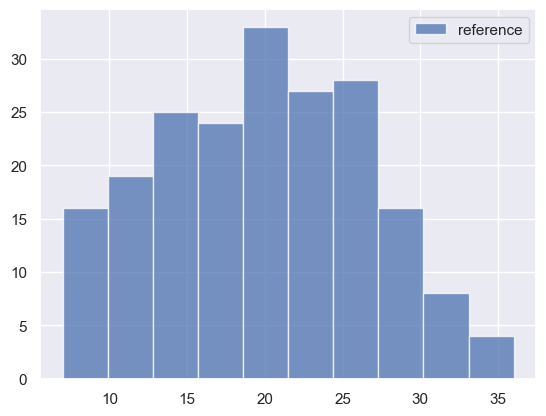

In [15]:
# Reference
df["num_tokens"] = df.text.apply(lambda x: len(x.split(" ")))
ref = df["num_tokens"][0:200].to_numpy()
plt.hist(ref, alpha=0.75, label="reference")
plt.legend()
plt.show()


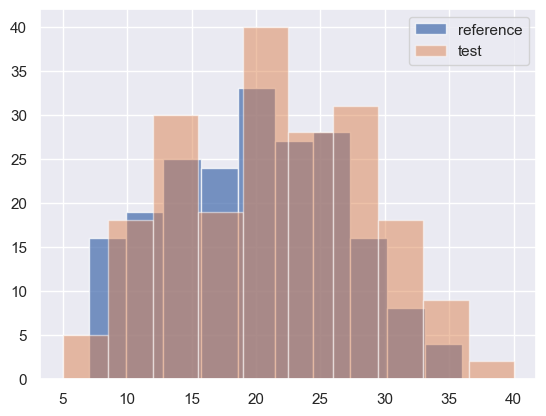

In [16]:
# Initialize drift detector
length_drift_detector = KSDrift(ref, p_val=0.01)


# No drift
no_drift = df["num_tokens"][200:400].to_numpy()
plt.hist(ref, alpha=0.75, label="reference")
plt.hist(no_drift, alpha=0.5, label="test")
plt.legend()
plt.show()


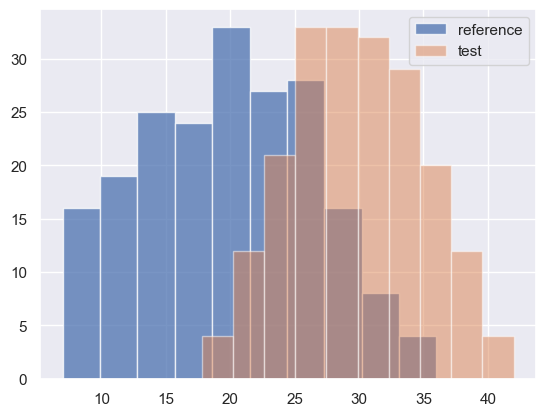

In [17]:
# Drift
drift = np.random.normal(30, 5, len(ref))
plt.hist(ref, alpha=0.75, label="reference")
plt.hist(drift, alpha=0.5, label="test")
plt.legend()
plt.show()


In [18]:
length_drift_detector.predict(drift, return_p_val=True, return_distance=True)


{'data': {'is_drift': 1,
  'distance': array([0.595], dtype=float32),
  'p_val': array([2.5649698e-34], dtype=float32),
  'threshold': 0.01},
 'meta': {'name': 'KSDrift',
  'online': False,
  'data_type': None,
  'version': '0.10.4',
  'detector_type': 'drift'}}

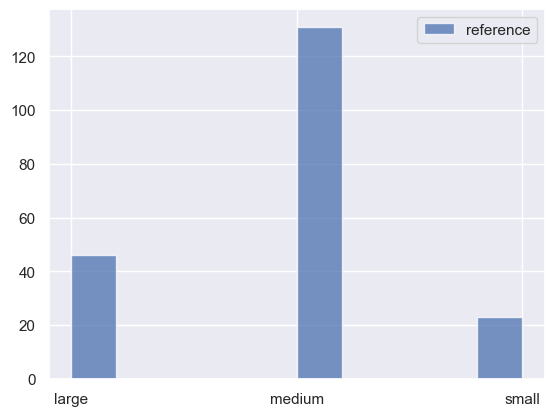

In [20]:
from alibi_detect.cd import ChiSquareDrift
# Reference
df.token_count = df.num_tokens.apply(lambda x: "small" if x <= 10 else ("medium" if x <=25 else "large"))
ref = df.token_count[0:200].to_numpy()
plt.hist(ref, alpha=0.75, label="reference")
plt.legend()
# Initialize drift detector
target_drift_detector = ChiSquareDrift(ref, p_val=0.01)



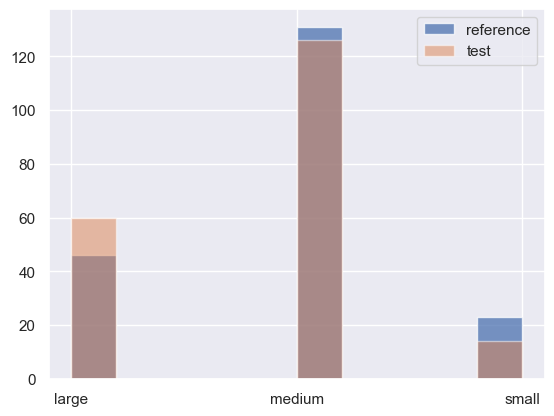

In [21]:
# No drift
no_drift = df.token_count[200:400].to_numpy()
plt.hist(ref, alpha=0.75, label="reference")
plt.hist(no_drift, alpha=0.5, label="test")
plt.legend()
plt.show()


In [22]:
target_drift_detector.predict(no_drift, return_p_val=True, return_distance=True)


{'data': {'is_drift': 0,
  'distance': array([4.135522], dtype=float32),
  'p_val': array([0.12646863], dtype=float32),
  'threshold': 0.01},
 'meta': {'name': 'ChiSquareDrift',
  'online': False,
  'data_type': None,
  'version': '0.10.4',
  'detector_type': 'drift'}}

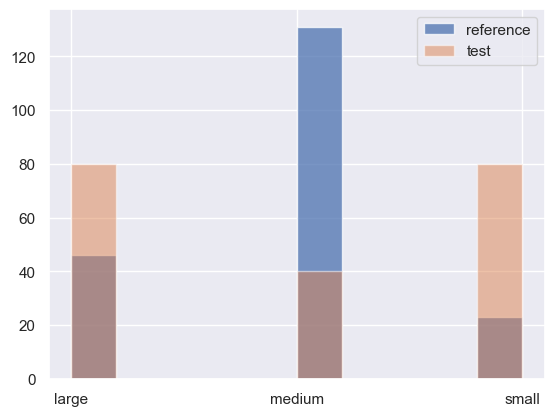

In [23]:
# Drift
drift = np.array(["small"]*80 + ["medium"]*40 + ["large"]*80)
plt.hist(ref, alpha=0.75, label="reference")
plt.hist(drift, alpha=0.5, label="test")
plt.legend()
plt.show()


In [24]:
target_drift_detector.predict(drift, return_p_val=True, return_distance=True)


{'data': {'is_drift': 1,
  'distance': array([89.145195], dtype=float32),
  'p_val': array([4.389017e-20], dtype=float32),
  'threshold': 0.01},
 'meta': {'name': 'ChiSquareDrift',
  'online': False,
  'data_type': None,
  'version': '0.10.4',
  'detector_type': 'drift'}}